In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Hackathon_ML-Model/AIML Dataset.csv")

In [8]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [12]:
df['step_day'] = df['step'].map(lambda x: x//24)
df['hour'] = df['step_day'].map(lambda x: x%24)
df['step_week'] = df['step_day'].map(lambda x: x//7)

In [14]:
df['ID_NO'] = df.nameOrig.map(lambda x: x[:1])
df['ID_NO'].value_counts()

C    6362620
Name: ID_NO, dtype: int64

In [15]:
df['ID_ND'] = df.nameDest.map(lambda x: x[:1])
df['ID_ND'].value_counts(1)

C    0.661854
M    0.338146
Name: ID_ND, dtype: float64

In [16]:
df['ID']=df['ID_NO']+df['ID_ND']
df['ID'].value_counts(1).round(2)

CC    0.66
CM    0.34
Name: ID, dtype: float64

In [19]:
df['wrong_orig_bal'] = np.where((df["oldBalanceOrig"] - df["amount"] - df["newBalanceOrig"]>0.01)|(df["oldBalanceOrig"] - df["amount"] - df["newBalanceOrig"]<-0.01),1,0)
df['wrong_dest_bal'] = np.where((df["newBalanceDest"] + df["amount"] - df["newBalanceDest"]>0.01)|(df["newBalanceDest"] + df["amount"] - df["newBalanceDest"]>0.01),1,0)

In [20]:
df.groupby(['wrong_orig_bal','isFraud']).size()

wrong_orig_bal  isFraud
0               0          1276761
                1             8168
1               0          5077646
                1               45
dtype: int64

In [23]:
De_Para_type={'type':['PAYMENT','TRANSFER','CASH_OUT','DEBIT','CASH_IN'],'type_num':[0,1,2,3,4]}
De_Para_ID={'ID':['CC','CM','MC','MM'],'ID_num':[0,1,10,11]}
df_Dp_type = pd.DataFrame(De_Para_type, columns = ['type', 'type_num'])
df_Dp_ID = pd.DataFrame(De_Para_ID, columns = ['ID', 'ID_num'])

In [24]:
df_temp = pd.merge(df, df_Dp_type, left_on='type', right_on='type')
df = pd.merge(df_temp, df_Dp_ID, left_on='ID', right_on='ID')
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,step_day,hour,step_week,ID_NO,ID_ND,ID,wrong_orig_bal,wrong_dest_bal,type_num,ID_num
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,C,M,CM,0,1,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,C,M,CM,0,1,0,1
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,C,M,CM,0,1,0,1
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0,0,0,0,C,M,CM,0,1,0,1
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0,0,0,0,C,M,CM,0,1,0,1


In [26]:
df_get_type = pd.get_dummies(df['type'], drop_first=True)
df = pd.concat([df,df_get_type],axis=1)
df_clean = df.drop(columns=['type','nameOrig','oldBalanceOrig','nameDest','oldBalanceDest','isFlaggedFraud'], axis=1)

In [27]:
df_clean = df_clean.drop(columns=['ID_NO','ID_ND','ID'], axis=1)

In [29]:
df_clean_Fraud = df_clean[df['isFraud']==1]
df_clean_Valid = df_clean[df['isFraud']==0]
df_clean_Valid = df_clean_Valid.sample(df_clean_Fraud.shape[0])

In [30]:
df_new = pd.concat([df_clean_Valid, df_clean_Fraud])

In [31]:
df_final=df_new
y_target = df_final['isFraud']
X=df_final.drop('isFraud', axis=1)
X.shape,y_target.shape[0]

((16426, 15), 16426)

In [37]:
X = X[["step", "amount", "newBalanceOrig", "newBalanceDest", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER" ]]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_target, test_size = 0.3, random_state = 26, stratify=y_target)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost.sklearn import XGBClassifier

classifiers = [
    KNeighborsClassifier(3),
    GaussianNB(),
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()]


for clf in classifiers:
    
    clf.fit(X_train, y_train)
    
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    y_pred = clf.predict(X_train)
    
    print("Accuracy:     ", round(metrics.accuracy_score(y_train, y_pred),4)*100)
    print("Precision:    ", round(metrics.precision_score(y_train, y_pred),4)*100)
    print("Recall:       ", round(metrics.recall_score(y_train, y_pred),4)*100)

KNeighborsClassifier
****Results****
Accuracy:      89.97
Precision:     90.75999999999999
Recall:        89.01
GaussianNB
****Results****
Accuracy:      73.39
Precision:     91.43
Recall:        51.61
LogisticRegression
****Results****
Accuracy:      69.23
Precision:     63.660000000000004
Recall:        89.62
SVC
****Results****
Accuracy:      77.23
Precision:     89.38000000000001
Recall:        61.8
DecisionTreeClassifier
****Results****
Accuracy:      100.0
Precision:     100.0
Recall:        100.0
RandomForestClassifier
****Results****
Accuracy:      100.0
Precision:     100.0
Recall:        100.0
GradientBoostingClassifier
****Results****
Accuracy:      93.65
Precision:     95.85000000000001
Recall:        91.25
XGBClassifier
****Results****
Accuracy:      93.46
Precision:     95.89
Recall:        90.82000000000001


In [41]:
# FINALIZING XGBOOST CLASSIFIER

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_train)


print("Accuracy:     ", round(metrics.accuracy_score(y_train, y_pred),4)*100)
print("Precision:    ", round(metrics.precision_score(y_train, y_pred),4)*100)
print("Recall:       ", round(metrics.recall_score(y_train, y_pred),4)*100)

Accuracy:      93.46
Precision:     95.89
Recall:        90.82000000000001


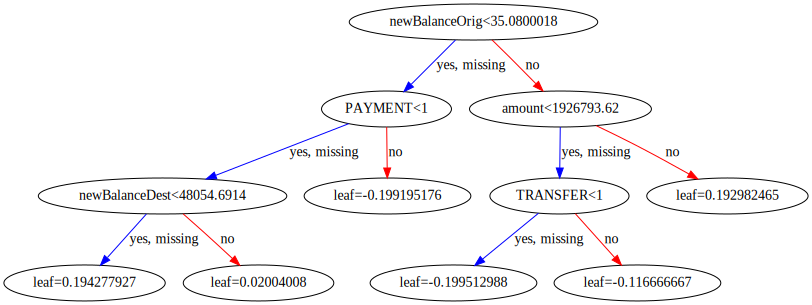

In [42]:
from xgboost import plot_importance, to_graphviz

to_graphviz(model)

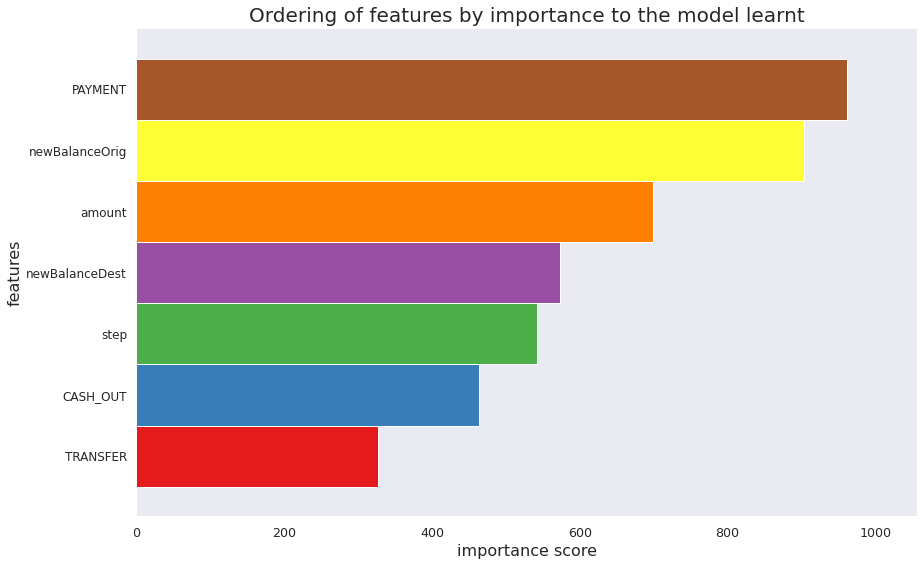

In [43]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);